# Refined Rohlik Sales Forecasting Challenge 2025

Rohlik Group, a leading European e-grocery innovator, operates across 11 warehouses in the Czech Republic, Germany, Austria, Hungary, and Romania.This notebook focuses on predicting the sales of selected warehouse inventory for the next 14 days using historical sales data, enabling more efficient inventory management and demand planning.

This is a cross-sectional time series forecasting regression, predicting daily **sales** of `unique_id` by **warehouse**, **discount type**, and **product type** while adjusting for **seasonal** factors and considering **holiday** effects.

This is a refined version based on insights gained from previous winners.

> config: !pip install scikit-learn==1.4.2 optuna==4.2.0 xgboost==2.1.3 category-encoders==2.7.0


In [99]:
import numpy as np 
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# 1) Reading and Merging Dataset

In [101]:
sales_train = pd.read_csv('data/sales_train.csv',parse_dates=['date'])
sales_test = pd.read_csv('data/sales_test.csv',parse_dates=['date'])
inventory = pd.read_csv('data/inventory.csv')
calendar = pd.read_csv('data/calendar.csv',parse_dates=['date'])
test_weights = pd.read_csv('data/test_weights.csv')
solution = pd.read_csv('data/solution.csv')

In [102]:
sales_train = pd.merge(sales_train, inventory, how='left', on =['unique_id','warehouse'])
sales_test = pd.merge(sales_test, inventory, how='left', on =['unique_id','warehouse'])
sales_train = pd.merge(sales_train, calendar, how='left', on =['date','warehouse'])
sales_test = pd.merge(sales_test, calendar, how='left', on =['date','warehouse'])

In [103]:
sales_train.sort_values(['date','warehouse'],inplace=True)

# 2) Handling Missing Values

In [105]:
sales_train.isnull().sum()

unique_id                       0
date                            0
warehouse                       0
total_orders                   52
sales                          52
sell_price_main                 0
availability                    0
type_0_discount                 0
type_1_discount                 0
type_2_discount                 0
type_3_discount                 0
type_4_discount                 0
type_5_discount                 0
type_6_discount                 0
product_unique_id               0
name                            0
L1_category_name_en             0
L2_category_name_en             0
L3_category_name_en             0
L4_category_name_en             0
holiday_name              3844119
holiday                         0
shops_closed                    0
winter_school_holidays          0
school_holidays                 0
dtype: int64

In [106]:
# Display rows where 'sales' is missing
missing_sales_rows = sales_train[sales_train['sales'].isnull()]
missing_sales_rows.head(3)

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays
154099,885,2021-05-21,Munich_1,NaN,NaN,4.02,1.0,0.0,0.0,0.0,...,Tomato_19,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_40,Fruit and vegetable_L4_1,NaN,0,0,0,0
738816,3778,2021-05-21,Munich_1,NaN,NaN,2.75,1.0,0.0,0.0,0.0,...,Carrot_25,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_33,Fruit and vegetable_L4_1,NaN,0,0,0,0
1028753,5152,2021-05-21,Munich_1,NaN,NaN,0.84,1.0,0.0,0.0,0.0,...,Cucumber_33,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_40,Fruit and vegetable_L4_1,NaN,0,0,0,0


Since 2021 was still affected by Covid lockdowns, we have chosen to use data starting from 2022. All missing values in the 'sales' column are from 2021, so there is no need to handle missing data.

In [108]:
sales_train["date"] = pd.to_datetime(sales_train["date"])
sales_train = sales_train[sales_train["date"]>'2021-12-31']

In [109]:
sales_train.head(3)

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays
3542,1755,2022-01-01,Brno_1,6706.0,94.88,29.74,1.0,0.00000,0.0,0.0,...,Cabbage_4,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_139,Fruit and vegetable_L4_1,New Years Day,1,1,0,0
5766,2706,2022-01-01,Brno_1,6706.0,123.52,41.70,1.0,0.08331,0.0,0.0,...,Potato_44,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_18,Fruit and vegetable_L4_1,New Years Day,1,1,0,0
18881,2005,2022-01-01,Brno_1,6706.0,28.64,43.68,1.0,0.00000,0.0,0.0,...,Kiwi_11,Fruit and vegetable,Fruit and vegetable_L2_1,Fruit and vegetable_L3_39,Fruit and vegetable_L4_52,New Years Day,1,1,0,0


# 3) Exploratory Data Analysis

## 3.1) Trend and Seasonality

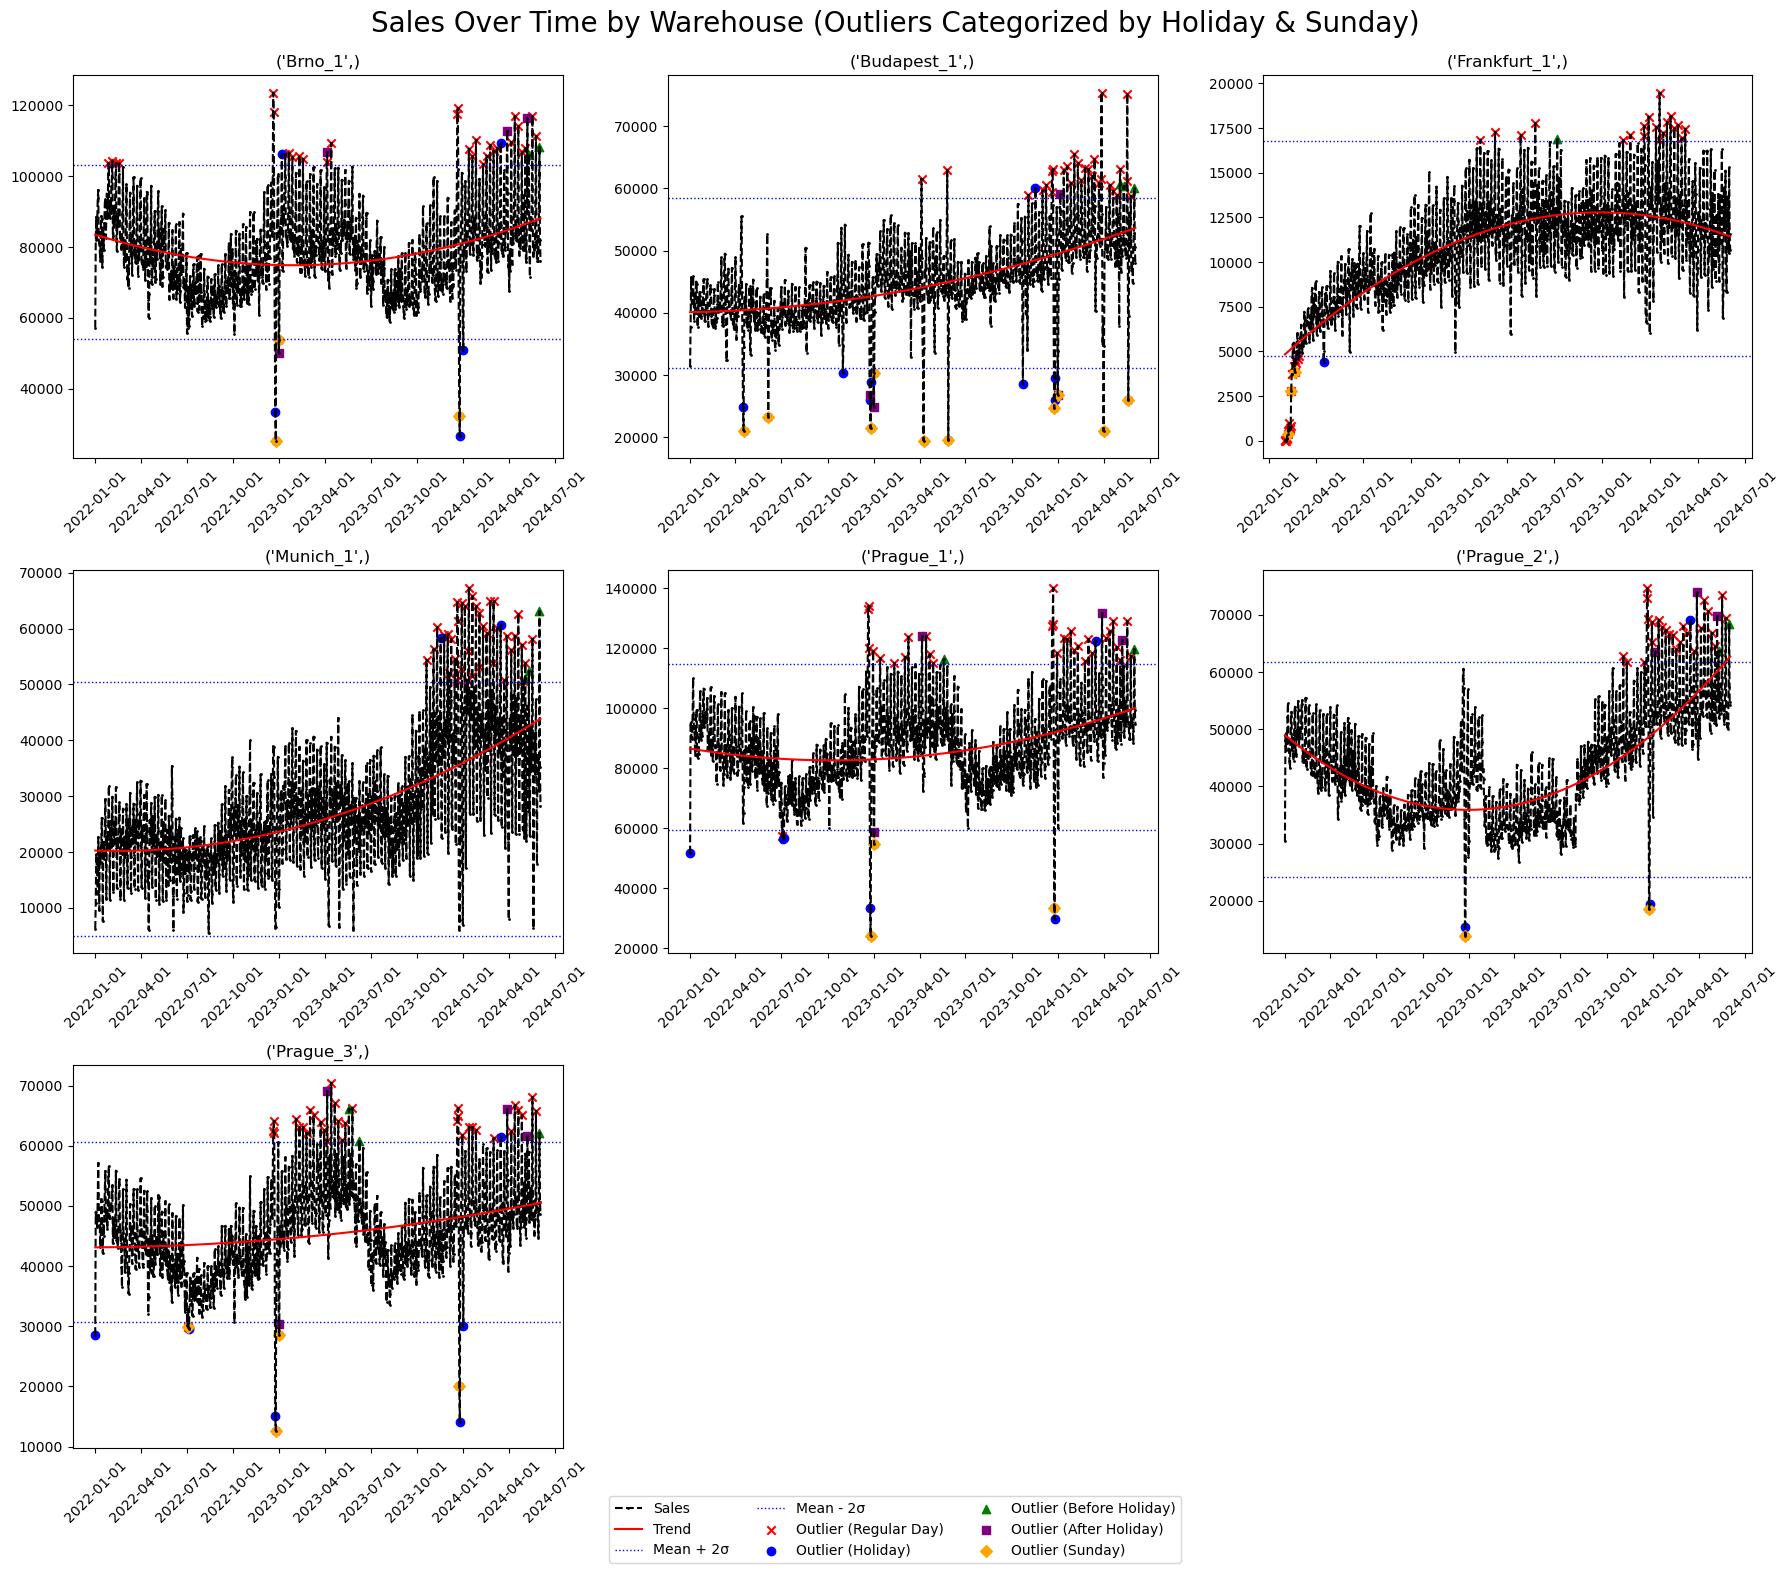

In [112]:
plt.figure(figsize=(18, 15))

# List of holiday dates
holiday_dates = sales_train[sales_train['holiday'] == 1]['date'].unique()

# Function to classify holiday status
def classify_holiday_status(row_date):
    if row_date in holiday_dates:
        return 'Holiday'
    elif row_date - pd.Timedelta(days=1) in holiday_dates:
        return 'Before Holiday'
    elif row_date + pd.Timedelta(days=1) in holiday_dates:
        return 'After Holiday'
    else:
        return 'Regular Day'

# Create an empty list to store legend handles and labels
legend_handles = []
legend_labels = []

for i, (comb, df) in enumerate(sales_train.groupby(['warehouse'], observed=False)):
    ax = plt.subplot(3, 3, i + 1)

    # Convert 'date' column to datetime format if not already
    df = df.reset_index()


    if df.empty:  # Skip if no data after the cutoff date
        continue

    # Aggregate sales by date and keep the 'holiday' flag
    sales = df.sort_values(by='date').groupby(['date'])[['sales', 'holiday']].sum().reset_index()
    sales['holiday_status'] = sales['date'].apply(classify_holiday_status)  # Classify holiday status
    sales['day_of_week'] = sales['date'].dt.dayofweek  # Extract day of the week
    sales['is_sunday'] = sales['day_of_week'] == 6  # Check if it's a Sunday

    trend = (sales.date - sales.iloc[0].date) // dt.timedelta(days=1)
    trend = trend.values.reshape(-1, 1)

    # Fit Polynomial Regression (degree=2)
    model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
    model.fit(trend, sales.sales)
    y_pred = pd.Series(model.predict(trend), index=sales.date)

    # Compute global mean and standard deviation for the full period
    overall_mean = sales.sales.mean()
    overall_std = sales.sales.std()

    # Compute overall ±2 standard deviation bounds
    upper_bound = overall_mean + 2 * overall_std
    lower_bound = overall_mean - 2 * overall_std

    # Identify outliers where sales exceed ±2σ
    outliers = sales[(sales.sales > upper_bound) | (sales.sales < lower_bound)]

    # Plot actual sales
    sales_line, = ax.plot(sales.date, sales.sales, label='Sales', color='black', marker='o', ls='--', markersize=1)

    # Plot trend line (polynomial regression)
    trend_line, = ax.plot(sales.date, y_pred, color='red', label='Trend')

    # Plot overall mean ± 2 std deviation bands
    upper_line = ax.axhline(upper_bound, color='blue', linestyle='dotted', linewidth=1, label='Mean + 2σ')
    lower_line = ax.axhline(lower_bound, color='blue', linestyle='dotted', linewidth=1, label='Mean - 2σ')

    # Highlight outliers with different markers:
    outliers_regular = ax.scatter(outliers[outliers.holiday_status == 'Regular Day'].date, 
                                  outliers[outliers.holiday_status == 'Regular Day'].sales, 
                                  color='red', marker='x', label='Outlier (Regular Day)')

    outliers_holiday = ax.scatter(outliers[outliers.holiday_status == 'Holiday'].date, 
                                  outliers[outliers.holiday_status == 'Holiday'].sales, 
                                  color='blue', marker='o', label='Outlier (Holiday)')

    outliers_before_holiday = ax.scatter(outliers[outliers.holiday_status == 'Before Holiday'].date, 
                                         outliers[outliers.holiday_status == 'Before Holiday'].sales, 
                                         color='green', marker='^', label='Outlier (Before Holiday)')

    outliers_after_holiday = ax.scatter(outliers[outliers.holiday_status == 'After Holiday'].date, 
                                        outliers[outliers.holiday_status == 'After Holiday'].sales, 
                                        color='purple', marker='s', label='Outlier (After Holiday)')

    outliers_sunday = ax.scatter(outliers[outliers.is_sunday].date, 
                                 outliers[outliers.is_sunday].sales, 
                                 color='orange', marker='D', label='Outlier (Sunday)')

    # Collect legend handles and labels
    if i == 0:  # Store only from the first subplot to avoid duplicates
        legend_handles.extend([sales_line, trend_line, upper_line, lower_line,
                               outliers_regular, outliers_holiday, 
                               outliers_before_holiday, outliers_after_holiday, outliers_sunday])
        legend_labels.extend(['Sales', 'Trend', 'Mean + 2σ', 'Mean - 2σ',
                              'Outlier (Regular Day)', 'Outlier (Holiday)', 
                              'Outlier (Before Holiday)', 'Outlier (After Holiday)', 'Outlier (Sunday)'])

    # Formatting
    ax.set_title(comb)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.suptitle('Sales Over Time by Warehouse (Outliers Categorized by Holiday & Sunday)', fontsize=20, y=1.02)

# Add a single legend below the entire plot
plt.figlegend(legend_handles, legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=3)

plt.show()


**Trend**: Most warehouses show an increasing sales trend, with Munich_1, Frankfurt_1, and Budapest_1 experiencing steady growth, while Brno_1, Prague_1, Prague_2, and Prague_3 follow a cyclical pattern.

**Seasonality**: Sales fluctuate periodically, likely due to seasonal demand, holidays, or retail cycles. Prague-based warehouses exhibit strong cyclical behavior, while Frankfurt_1 shows a steadier upward trend.

**Outliers**: High sales spikes (red) often occur around holidays, while significant drops (blue) align with Sundays. 

**Key Insight**: Sales are influenced by long-term growth, seasonal trends, and specific events (holidays, Sundays). Understanding these patterns can help optimize inventory and business strategies.

## 3.2) Distribution by Product Features

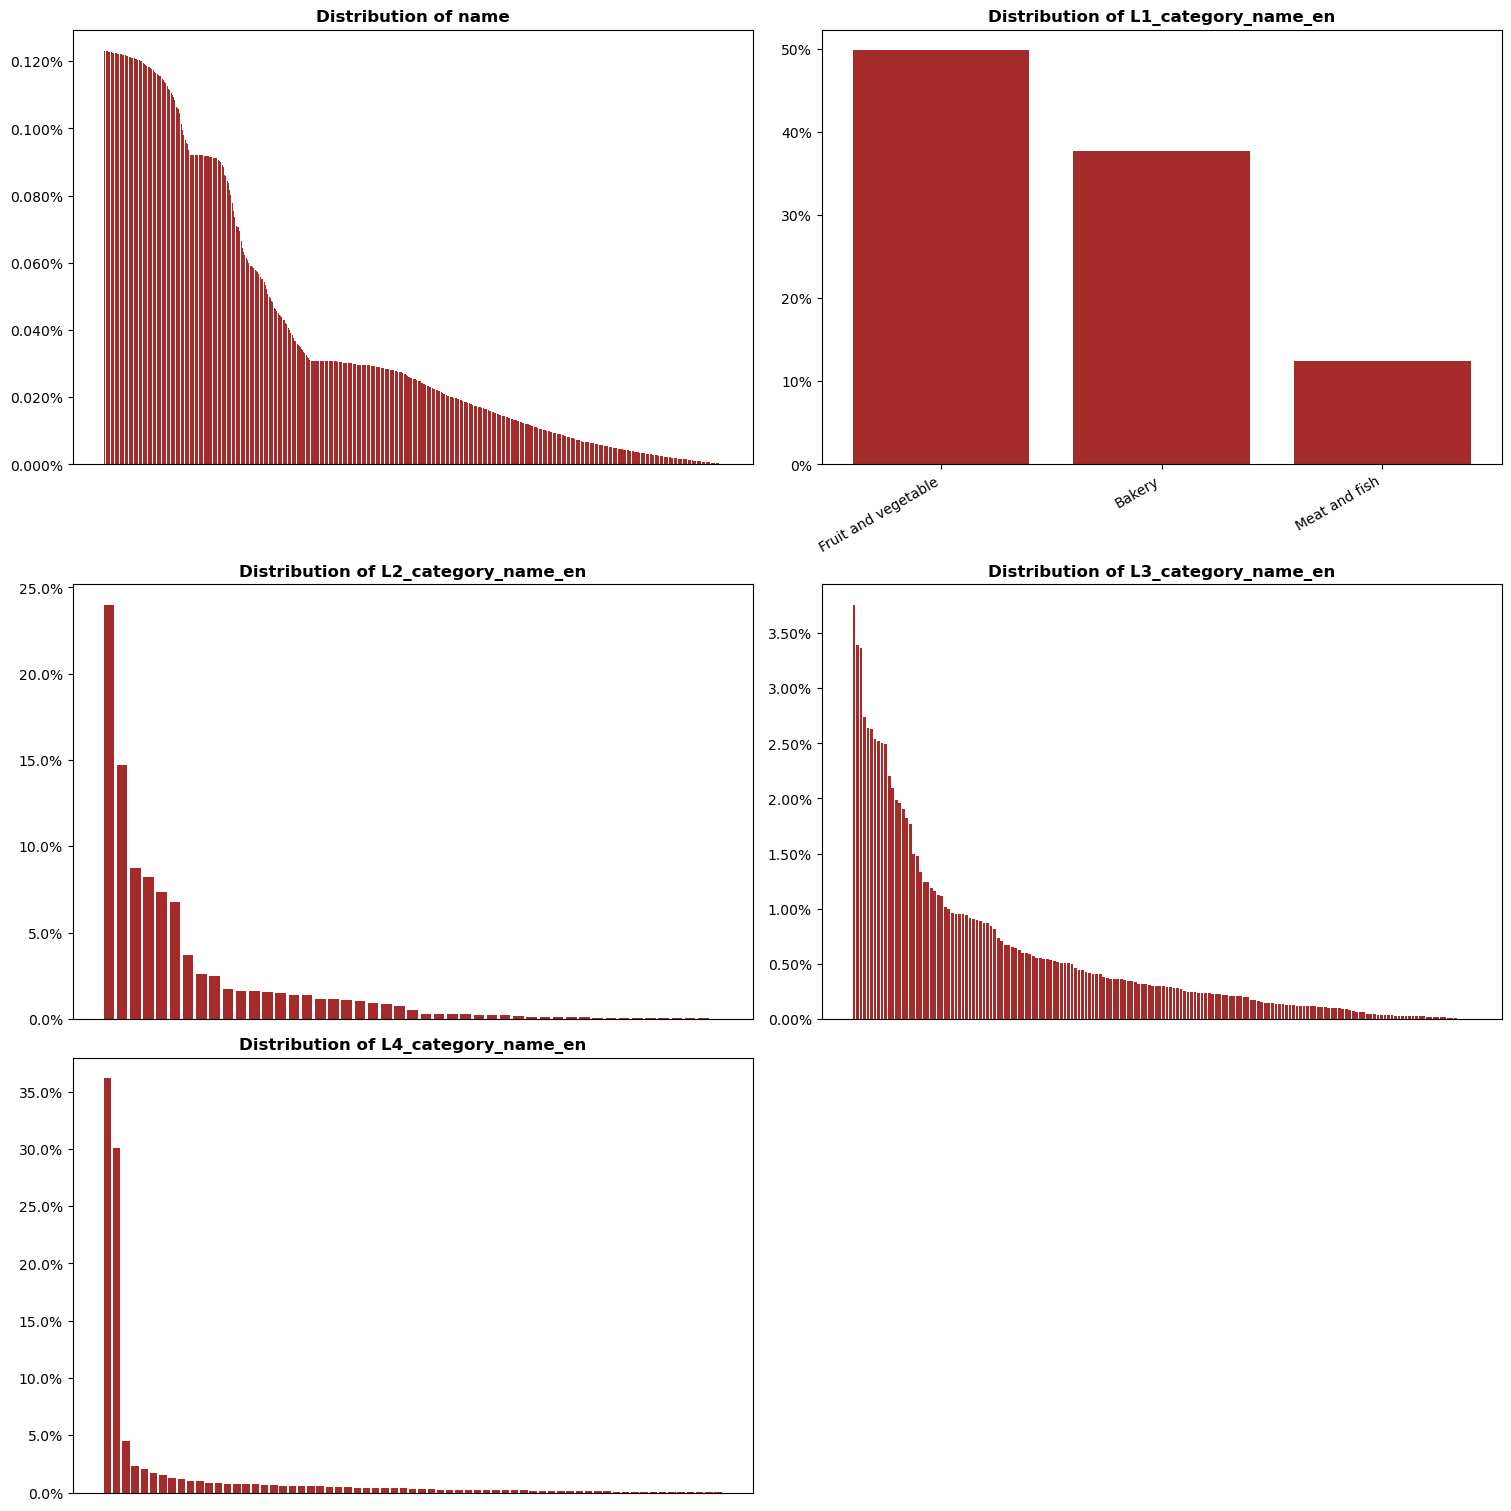

In [115]:
from matplotlib.ticker import PercentFormatter

products_col = ['name', 'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en']

for col in products_col:
    sales_train[col] = sales_train[col].astype('category')

fig, axs = plt.subplots(3, 2, figsize=(15, 15), constrained_layout=True)
axs = axs.ravel()

# Plot distributions
for i, c in enumerate(products_col):
    vc = sales_train[c].value_counts() / len(sales_train)
    axs[i].bar(vc.index, vc, color='brown')
    axs[i].yaxis.set_major_formatter(PercentFormatter(1.0))  # Format y-axis as percentage
    
    if len(vc) <= 15:
        axs[i].set_xticks(range(len(vc.index)))
        axs[i].set_xticklabels(vc.index, rotation=30, ha='right')
    else:
        axs[i].set_xticks([])  # Hide xticks if too many categories

    axs[i].set_title(f'Distribution of {c}', fontweight='bold')

# Hide empty subplots if the number of features is less than the grid size
for j in range(len(products_col), len(axs)):
    axs[j].set_visible(False)

plt.show()


> The dataset's product names (name) follow a right-skewed distribution, with a few products appearing frequently while most are rare. At the highest category level (L1), "Fruit and vegetable" is the most common, followed by "Bakery" and "Meat and fish." Subcategories (L2 and L3) also exhibit a long-tail distribution, where a few dominate while most have lower representation.

## 3.3) Discount Type

Rohlik runs various types of promotional sales, where discounts are calculated as:
$$
\text{Discount Percentage} = \frac{\text{Original Price} - \text{Current Price}}{\text{Original Price}}
$$

**Key Points**:
- Multiple discount types can be active simultaneously.
- The **highest possible discount** among these is applied.
- **Negative discount values** indicate **no discount**.

Therefore, we need to preprocess the data before EDA.

In [119]:
# Ensure discount values are non-negative
discount_columns_train = ['type_0_discount', 'type_1_discount', 'type_2_discount',
                          'type_3_discount', 'type_4_discount', 'type_5_discount', 'type_6_discount']
sales_train[discount_columns_train] = sales_train[discount_columns_train].clip(lower=0)

discount_columns_test = ['type_0_discount', 'type_1_discount', 'type_2_discount',
                         'type_3_discount', 'type_4_discount', 'type_5_discount', 'type_6_discount']
sales_test[discount_columns_test] = sales_test[discount_columns_test].clip(lower=0)

# Identify the discount type with the highest value
sales_train['discount_type'] = sales_train[discount_columns_train].idxmax(axis=1)
sales_train['discount_type'] = sales_train['discount_type'].str.extract(r'type_(\d+)_discount').astype(object)

sales_test['discount_type'] = sales_test[discount_columns_test].idxmax(axis=1)
sales_test['discount_type'] = sales_test['discount_type'].str.extract(r'type_(\d+)_discount').astype(object)

# Add 'discount_max' column
sales_train['discount_max'] = sales_train[discount_columns_train].max(axis=1)
sales_test['discount_max'] = sales_test[discount_columns_test].max(axis=1)

#Assign "No Discount" where all discount values are 0
sales_train.loc[sales_train['discount_max'] == 0, 'discount_type'] = "No Discount"
sales_test.loc[sales_test['discount_max'] == 0, 'discount_type'] = "No Discount"

# # Convert discount_type to a mix of integers and strings
sales_train['discount_type'] = sales_train['discount_type'].astype('category')
sales_test['discount_type'] = sales_test['discount_type'].astype('category')

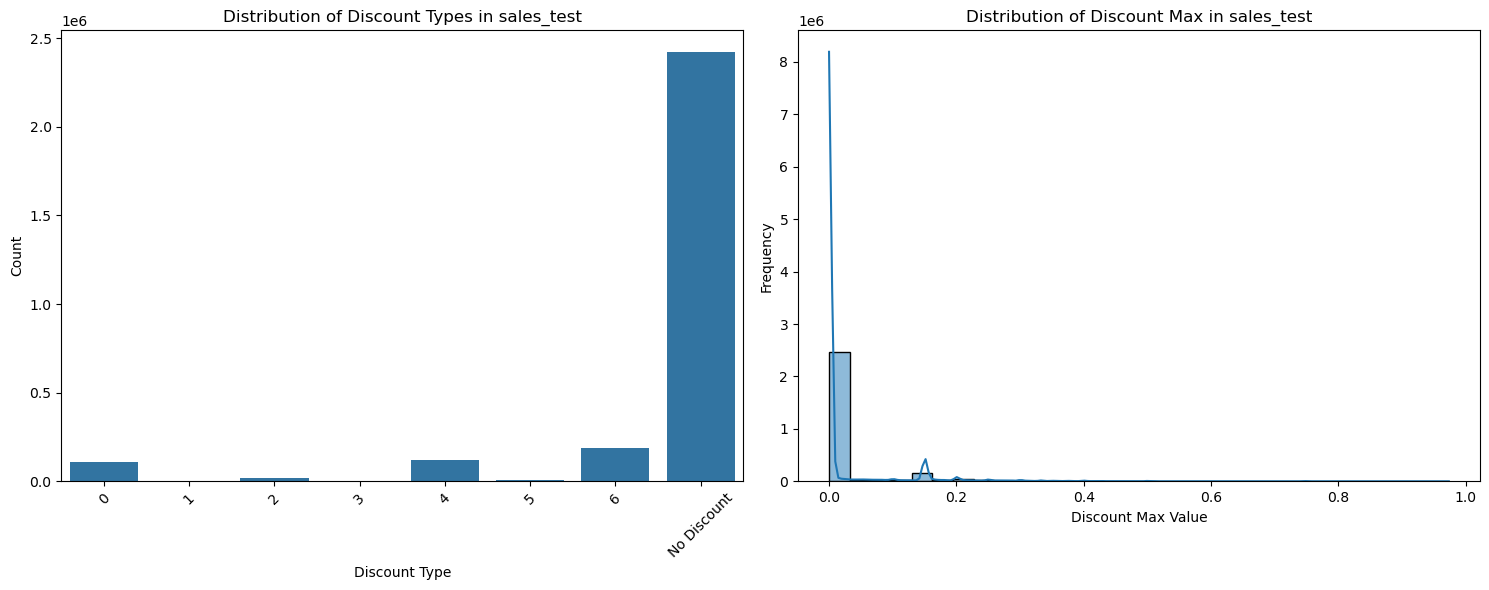

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot bar chart for discount_type in sales_test
sns.barplot(x=sales_train['discount_type'].value_counts().index, 
            y=sales_train['discount_type'].value_counts().values, ax=axes[0])
axes[0].set_xlabel("Discount Type")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Discount Types in sales_test")
axes[0].tick_params(axis='x', rotation=45)

# Plot distribution for discount_max in sales_test
sns.histplot(sales_train['discount_max'], bins=30, kde=True, ax=axes[1])
axes[1].set_xlabel("Discount Max Value")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Discount Max in sales_test")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Key Takeaways:
1) Discounting is rare in the dataset, with most transactions having no discount.
2) The dataset has a strong imbalance in discount types.
3) The discount amount is mostly low, suggesting that when discounts occur, they are usually small.

# 4) Feature Engineering

## 4.1) Matching the mean availability to the unique_id in the test set

In [124]:
availability_avg = sales_train.groupby('unique_id', as_index=False)['availability'].mean()
sales_train.drop(['availability'], axis=1, inplace=True)
sales_train = pd.merge(sales_train, availability_avg, how='left', on =['unique_id'])
sales_test = pd.merge(sales_test, availability_avg, how='left', on =['unique_id'])

## 4.2) Extracting Days in Sale and Purchase Interval by Product

In [126]:
my_index = sales_train.index
my_index_ts = sales_test.index

agg_df = sales_train.reset_index().groupby(['name'],observed=False).agg(days_in_sale=('date','nunique'),
                                                                   purchase_interval=('date',lambda x: (x.max() - x.min()).days)                                                               
                                                                  ).reset_index()
sales_train = sales_train.merge(agg_df[['name', 'days_in_sale', 'purchase_interval']], on='name', how='left')
sales_test = sales_test.merge(agg_df[['name', 'days_in_sale', 'purchase_interval']], on='name', how='left')

sales_train.set_index(my_index,inplace=True)
sales_test.set_index(my_index_ts,inplace=True)

## 4.3) Adding Temporal Factors, Extracting Name and Product Price Trend

In [128]:
def fe_date(df):
    df['year'] = df['date'].dt.year
    df['day_of_week'] = df['date'].dt.dayofweek
    df['days_since_2022'] = (df['date'] - pd.to_datetime('2022-01-01')).dt.days.astype('int')
    df['day_of_year'] = df['date'].dt.dayofyear
    df['cos_day'] = np.cos(df['day_of_year']*2*np.pi/365)
    df['sin_day'] = np.sin(df['day_of_year']*2*np.pi/365)

def fe_other(df):
    discount_cols = ['type_0_discount','type_1_discount','type_2_discount','type_3_discount','type_4_discount','type_5_discount','type_6_discount']
    df[discount_cols] = df[discount_cols].clip(0)
    df['max_discount'] = df[['type_0_discount','type_1_discount','type_2_discount','type_3_discount','type_4_discount','type_5_discount']].max(axis=1)
    df['common_name'] = df['name'].apply(lambda x: x[:x.find('_')])
    df['CN_total_products'] = df.groupby(['date','warehouse','common_name'])['unique_id'].transform('nunique')
    df['CN_discount_avg'] = df.groupby(['date','warehouse','common_name'])['max_discount'].transform('mean')
    df['CN_WH'] = df['common_name'] + '_' + df['warehouse']
    df['name_num_warehouses'] = df.groupby(['date', 'name'], observed=True)['unique_id'].transform('nunique')

# It is hard to test the rolling windows as the computing power is limited
def fe_combined(df):
    df['num_sales_days_28D'] = pd.MultiIndex.from_frame(df[['unique_id','date']]).map(df.sort_values('date').groupby('unique_id').rolling(
        window='28D', on='date', closed='left')['date'].count().fillna(0))
    mean_prices = df.groupby(df['unique_id'])['sell_price_main'].mean()
    std_prices = df.groupby(df['unique_id'])['sell_price_main'].std()
    df['price_scaled'] = np.where(df['unique_id'].map(std_prices) == 0, 0, 
                                  (df['sell_price_main'] - df['unique_id'].map(mean_prices))/df['unique_id'].map(std_prices))
    df['price_detrended'] = df['price_scaled'] - df.groupby(['days_since_2022','warehouse'])['price_scaled'].transform('mean')
    df.drop('price_scaled',axis=1,inplace=True)

    warehouse_stats = df.groupby(['date','warehouse'])['total_orders'].median().rename('med_total_orders').reset_index().sort_values('date')
    warehouse_stats['ewmean_orders_56'] = warehouse_stats.groupby('warehouse')['med_total_orders'].transform(lambda x:x.ewm(alpha=1/56).mean())
    df['mean_orders_14d'] = pd.MultiIndex.from_frame(df[['warehouse','date']]).map(
        warehouse_stats.groupby('warehouse').rolling(on='date',window='14D')['med_total_orders'].mean())
    df['ewmean_orders_56'] = pd.MultiIndex.from_frame(df[['warehouse','date']]).map(
        warehouse_stats.set_index(['warehouse','date'])['ewmean_orders_56'])
    return df

In [129]:
sales_train['id'] = sales_train['unique_id'].astype('str') + '_' + sales_train['date'].astype('str')
sales_train.set_index('id',inplace=True)
sales_train = sales_train[~sales_train['sales'].isna()]
fe_date(sales_train)
fe_other(sales_train)

sales_test['id'] = sales_test['unique_id'].astype('str') + '_' + sales_test['date'].astype('str')
sales_test.set_index('id',inplace=True)
fe_date(sales_test)
fe_other(sales_test)

all_data = pd.concat([sales_train,sales_test])
all_data = fe_combined(all_data)
sales_train = all_data.loc[sales_train.index]
sales_test = all_data.loc[sales_test.index].drop(['sales'],axis=1)

In [130]:
#Drop original discount columns
sales_train.drop(columns=discount_columns_train, inplace=True)
sales_test.drop(columns=discount_columns_test, inplace=True)

In [131]:
sales_train.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,product_unique_id,name,L1_category_name_en,L2_category_name_en,...,max_discount,common_name,CN_total_products,CN_discount_avg,CN_WH,name_num_warehouses,num_sales_days_28D,price_detrended,mean_orders_14d,ewmean_orders_56
id,,,,,,,,,,,,,,,,,,,,,
1755_2022-01-01,1755,2022-01-01,Brno_1,6706.0,94.88,29.74,892,Cabbage_4,Fruit and vegetable,Fruit and vegetable_L2_3,...,0.00000,Cabbage,6,0.000000,Cabbage_Brno_1,4,0.0,0.569927,6706.0,6706.0
2706_2022-01-01,2706,2022-01-01,Brno_1,6706.0,123.52,41.70,1346,Potato_44,Fruit and vegetable,Fruit and vegetable_L2_3,...,0.08331,Potato,11,0.007574,Potato_Brno_1,4,0.0,0.257013,6706.0,6706.0
2005_2022-01-01,2005,2022-01-01,Brno_1,6706.0,28.64,43.68,1013,Kiwi_11,Fruit and vegetable,Fruit and vegetable_L2_1,...,0.00000,Kiwi,5,0.000000,Kiwi_Brno_1,4,0.0,1.011986,6706.0,6706.0
5033_2022-01-01,5033,2022-01-01,Brno_1,6706.0,44.75,51.54,2465,Physalis_2,Fruit and vegetable,Fruit and vegetable_L2_1,...,0.00000,Physalis,2,0.000000,Physalis_Brno_1,4,0.0,1.601075,6706.0,6706.0
2468_2022-01-01,2468,2022-01-01,Brno_1,6706.0,1793.76,54.31,1232,Blueberry_17,Fruit and vegetable,Fruit and vegetable_L2_1,...,0.21480,Blueberry,3,0.071600,Blueberry_Brno_1,4,0.0,-0.878915,6706.0,6706.0


In [132]:
sales_test.head()

,unique_id,date,warehouse,total_orders,sell_price_main,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,...,max_discount,common_name,CN_total_products,CN_discount_avg,CN_WH,name_num_warehouses,num_sales_days_28D,price_detrended,mean_orders_14d,ewmean_orders_56
id,,,,,,,,,,,,,,,,,,,,,
1226_2024-06-03,1226,2024-06-03,Brno_1,8679.0,13.13,627,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,...,0.00000,Croissant,10,0.000000,Croissant_Brno_1,4,28.0,-0.286523,8986.142857,9053.378872
1226_2024-06-11,1226,2024-06-11,Brno_1,8795.0,13.13,627,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,...,0.15873,Croissant,10,0.080228,Croissant_Brno_1,4,28.0,-0.256140,8949.714286,9030.457061
1226_2024-06-13,1226,2024-06-13,Brno_1,10009.0,13.13,627,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,...,0.15873,Croissant,10,0.080228,Croissant_Brno_1,4,28.0,-0.200774,8987.071429,9047.431957
1226_2024-06-15,1226,2024-06-15,Brno_1,8482.0,13.13,627,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,...,0.15873,Croissant,10,0.080228,Croissant_Brno_1,4,28.0,-0.240994,8977.785714,9060.407740
1226_2024-06-09,1226,2024-06-09,Brno_1,8195.0,13.13,627,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,...,0.00000,Croissant,10,0.000000,Croissant_Brno_1,4,28.0,-0.311008,8880.071429,9030.369701


## 4.4) Features Selection

In [134]:
cat_cols = list(sales_test.select_dtypes(include='O'))
num_cols = list(sales_test._get_numeric_data())
target = 'sales'
initial_features = list(sales_test.columns)

In [135]:
for c in cat_cols:    
    A = sales_train[c].fillna('None').astype(str).unique()
    B = sales_test[c].fillna('None').astype(str).unique()
    C = np.setdiff1d(B,A)
    if C.size>0:
        print(C)
        sales_train.iloc[~sales_train[c].isin(C), c ] = 'None'
    sales_train[c] = sales_train[c].astype('category')
    sales_test[c] = sales_test[c].astype('category')    

In [136]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2869127 entries, 1755_2022-01-01 to 5368_2024-06-02
Data columns (total 38 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   unique_id               int64         
 1   date                    datetime64[ns]
 2   warehouse               category      
 3   total_orders            float64       
 4   sales                   float64       
 5   sell_price_main         float64       
 6   product_unique_id       int64         
 7   name                    category      
 8   L1_category_name_en     category      
 9   L2_category_name_en     category      
 10  L3_category_name_en     category      
 11  L4_category_name_en     category      
 12  holiday_name            category      
 13  holiday                 int64         
 14  shops_closed            int64         
 15  winter_school_holidays  int64         
 16  school_holidays         int64         
 17  discount_type           categ

In [137]:
sales_train = sales_train.drop(columns=['product_unique_id'])
sales_test = sales_test.drop(columns=['product_unique_id'])

In [138]:
# List of features to remove
features_to_remove = [
    'product_unique_id',
    'date',
    'discount_max',
    'L1_category_name_en',
    'winter_school_holidays',
    'school_holidays'
]

# Remove each feature in the list
for feature in features_to_remove:
    if feature in initial_features:
        initial_features.remove(feature)


In [139]:
features = list(initial_features )

# 5) Building Models and Optimization

> I attempted to use a deep neural network to build entity embeddings for handling product names, but it required excessive computational power without yielding significant improvement. Additionally, I tried Lasso and Elastic Net, but due to the dataset's inherent non-linearity, their performance was poor, with a WMAP exceeding 50, making them unsuitable for ensembling. Ultimately, XGBoost consistently outperformed LightGBM, so I decided to use only XGBoost in the later stages of the project.

In [52]:
weight_map = test_weights.set_index('unique_id')['weight'].to_dict()

## XGBoost

> Although the time series starts from 2022, it still contains approximately 2.8 million samples with 33 features. I spent a significant amount of time optimizing the model and even subscribed to Google Colab to accelerate training. However, I could only manually select certain periods as the validation set due to lack of computing power. Finally, the best WMAP I achieved was 19.63, which is 1.8 higher than the fourth-place result in the competition, ranking me 164th out of 777 participants.

In [63]:
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from category_encoders import TargetEncoder

# Define Optuna's objective function
def objective(trial):
    # I applied a much wider range and trials during the compeition by Google Colab
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # Updated
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),                    # Updated
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)       # Updated
    }

    # Split the data: 80% train, 20% validation
    X = sales_train[features].copy()
    y = sales_train['sales'].copy()
    cutoff = int(len(X) * 0.9)

    X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
    X_val, y_val = X.iloc[cutoff:], y.iloc[cutoff:]

    # Define the model and pipeline
    model = make_pipeline(
        TargetEncoder(cols=['name', 'holiday_name', 'L2_category_name_en', 
                            'L3_category_name_en', 'L4_category_name_en']),
        XGBRegressor(verbosity=0, enable_categorical=True, **params)
    )

    # Train the model on the training set
    model.fit(X_train.drop('unique_id', axis=1), np.log(y_train + 1))

    # Validate on the holdout set
    y_pred = np.exp(model.predict(X_val.drop('unique_id', axis=1)).clip(0, None)) - 1

    # Calculate WMAE
    wmape = mean_absolute_error(
        y_val, 
        y_pred, 
        sample_weight=X_val["unique_id"].map(weight_map).values
    )

    return wmape

# Run Optuna study with updated methods
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Output best parameters and score
print("Best parameters:", study.best_params)
print("Best WMAE:", study.best_value)


[I 2025-02-18 02:12:11,864] A new study created in memory with name: no-name-1952641a-6f54-4dd7-833b-16da41e292bb
[I 2025-02-18 02:12:58,673] Trial 0 finished with value: 23.368924476013405 and parameters: {'n_estimators': 401, 'max_depth': 8, 'learning_rate': 0.09119344734819794, 'subsample': 0.5209025834406393, 'colsample_bytree': 0.9127866183621787}. Best is trial 0 with value: 23.368924476013405.
[W 2025-02-18 02:13:52,156] Trial 1 failed with parameters: {'n_estimators': 583, 'max_depth': 10, 'learning_rate': 0.18436170053785103, 'subsample': 0.533209785300586, 'colsample_bytree': 0.5718393481259381} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/1_/kry0zmp545j7x_x7n8zynb8h0000gn/T/ipykernel_8240/2588848496.py", line 34, in objective
    model.fit(X_t

KeyboardInterrupt: 

In [39]:
study.best_params

{'n_estimators': 959,
 'max_depth': 9,
 'learning_rate': 0.07086590423121661,
 'subsample': 0.8514262985534982,
 'colsample_bytree': 0.502128401421563}

In [167]:
import numpy as np
from xgboost import XGBRegressor
from category_encoders import TargetEncoder
from sklearn.pipeline import make_pipeline

# Extract train data
X_train = sales_train[features].drop('unique_id', axis=1)
y_train = sales_train[target]

# Define model with the given hyperparameters
# xgb_params = study.best_params

#sample parameters by Google Colab training
xgb_params ={'n_estimators': 964,
 'max_depth': 10,
 'learning_rate': 0.06321009582224273,
 'subsample': 0.959182924821568,
 'colsample_bytree': 0.6258672261433101}


# Create a pipeline
model = make_pipeline(
    TargetEncoder(cols=['name', 'holiday_name', 'L2_category_name_en',
                        'L3_category_name_en', 'L4_category_name_en']),
    XGBRegressor(verbosity= 0,enable_categorical= True, **xgb_params)
)

# Train the model
model.fit(X_train, np.log(y_train + 1))

# Make predictions on the test set
sales_hat = np.exp(
    model.predict(sales_test[features].drop('unique_id', axis=1)).clip(0, None)
) - 1


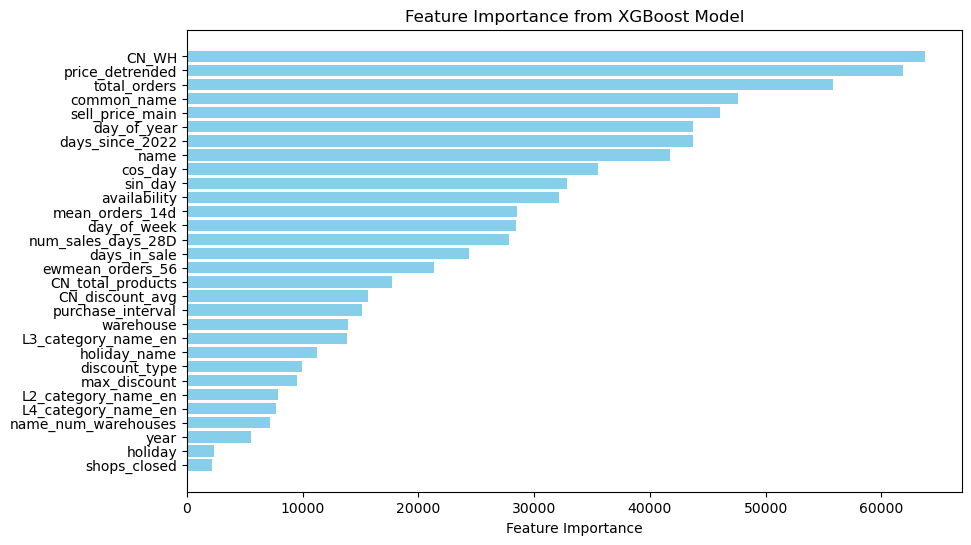

In [168]:
xgb_model = model.named_steps['xgbregressor']

# Get feature importance from the XGBoost model
feature_importance = xgb_model.get_booster().get_score(importance_type='weight')

# Convert feature importance to a sorted list for visualization
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Separate features and importance values
f, importances = zip(*sorted_features)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(f, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from XGBoost Model')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()


In [169]:
sol = pd.DataFrame({
    'id': solution['id'],
    'sales_hat': sales_hat
})

In [170]:
import os

base_filename = "submission_l"
version = 1
filename = f"{base_filename}{version}.csv"

# Debugging: Check if the file exists
while os.path.exists(filename):
    print(f"File {filename} already exists. Incrementing version...")
    version += 1
    filename = f"{base_filename}{version}.csv"

# Now save
sol.to_csv(filename, index=False)
print(f"File saved as: {filename}")


File submission_l1.csv already exists. Incrementing version...
File submission_l2.csv already exists. Incrementing version...
File submission_l3.csv already exists. Incrementing version...
File saved as: submission_l4.csv


In [171]:
pd.DataFrame(sales_hat).describe()

,0
count,47021.000000
mean,63.829121
std,120.039993
min,0.000000
25%,23.699938
50%,37.758156
75%,64.550125
max,3628.893311


In [172]:
sales_train['sales'].describe()

count    2.869127e+06
mean     1.038573e+02
std      3.615521e+02
min      0.000000e+00
25%      1.771000e+01
50%      3.775000e+01
75%      8.937000e+01
max      2.631619e+04
Name: sales, dtype: float64

## LightGBM

In [ ]:
# import optuna
# import numpy as np
# import pandas as pd
# from sklearn.metrics import mean_absolute_error
# from sklearn.pipeline import make_pipeline
# from category_encoders import TargetEncoder
# from lightgbm import LGBMRegressor

# # Define features
# features = initial_features + ['days_in_sale', 'purchase_interval']

# # Define Optuna's objective function
# def objective(trial):
#     # Hyperparameters to optimize
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # Updated
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),                    # Updated
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),      # Updated
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),                   # L1 regularization
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0)                  # L2 regularization
#     }

#     # Split the data: 80% train, 20% validation
#     X = sales_train[features].copy()
#     y = sales_train['sales'].copy()
#     cutoff = int(len(X) * 0.92)

#     X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
#     X_val, y_val = X.iloc[cutoff:], y.iloc[cutoff:]

#     # Define the model and pipeline
#     model = make_pipeline(
#         TargetEncoder(cols=['name', 'holiday_name', 'L2_category_name_en', 
#                             'L3_category_name_en', 'L4_category_name_en']),
#         LGBMRegressor(objective='regression', **params)
#     )

#     # Train the model on the training set
#     model.fit(X_train.drop('unique_id', axis=1), np.log(y_train + 1))

#     # Validate on the holdout set
#     y_pred = np.exp(model.predict(X_val.drop('unique_id', axis=1)).clip(0, None)) - 1

#     # Calculate WMAE
#     wmape = mean_absolute_error(
#         y_val, 
#         y_pred, 
#         sample_weight=X_val["unique_id"].map(weight_map).values
#     )

#     return wmape

# # Run Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # Output best parameters and score
# print("Best parameters:", study.best_params)
# print("Best WMAE:", study.best_value)


[I 2025-02-14 23:08:20,744] A new study created in memory with name: no-name-3bfb87bc-897b-41ac-8dad-dff31cd46370


In [ ]:
# study.best_params

In [ ]:
# import numpy as np
# from lightgbm import LGBMRegressor
# from category_encoders import TargetEncoder


# # Extract train data
# X_train = sales_train[features].drop('unique_id', axis=1)
# y_train = sales_train[target]

# # Define LightGBM hyperparameters (copied/adapted from XGBoost)
# lgbm_params = study.best_params

# # Create a pipeline
# model = make_pipeline(
#     TargetEncoder(cols=['name', 'holiday_name', 'L2_category_name_en',
#                         'L3_category_name_en', 'L4_category_name_en']),
#     LGBMRegressor(objective='regression', **lgbm_params)
# )

# # Train the model
# model.fit(X_train, np.log(y_train + 1))

# # Make predictions on the test set
# sales_hat = np.exp(
#     model.predict(sales_test[features].drop('unique_id', axis=1)).clip(0, None)
# ) - 1


In [ ]:
# sales_hat

In [ ]:
# sol = pd.DataFrame({
#     'id': solution['id'],
#     'sales_hat': sales_hat
# })

In [ ]:
# sol.to_csv('submission_w5.csv',index=False)